### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.convert import array_to_table
from pyrsgis.ml import imageChipsFromArray
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from statistics import mean
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_Landsat9.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualising spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_cl…

### Normalising

In [4]:
arrFeatures = array_to_table(arrFeatures)
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

# normalise the image
for i in range(arrFeatures.shape[1]):
    bandMin = arrFeatures[:, i].min()
    bandMax = arrFeatures[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[0]):
        arrFeatures_fuzzy[j, i] = (arrFeatures[j, i]-bandMin)/bandRange

### Loading the training dataset (manual)

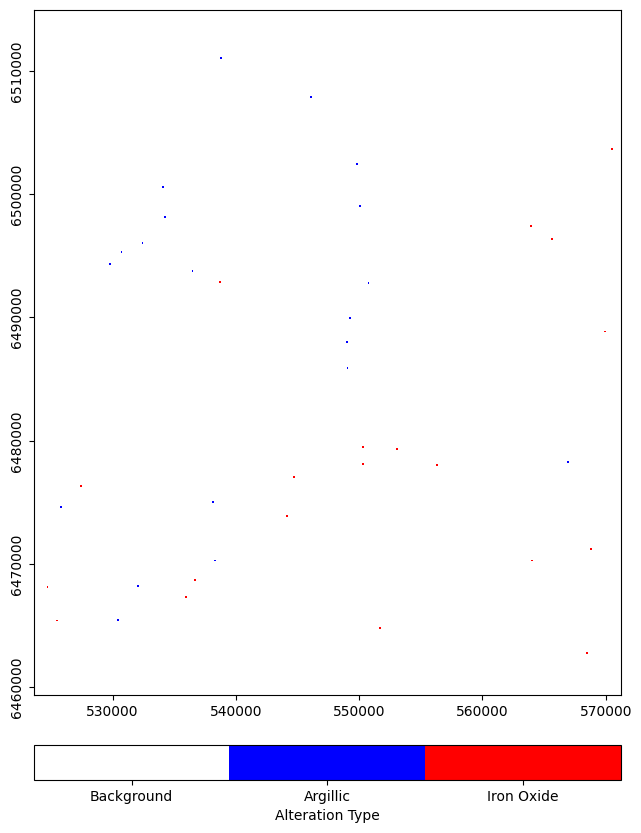

In [5]:
positiveLabel_file = './BrokenHill_Landsat8_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels_manual, arrPositiveLabels_manual = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels_manual))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels_manual, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels_manual)
index = np.transpose(np.where(arrPositiveLabels_manual==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels_manual.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_manual_flat = arrPositiveLabels_manual.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_manual_flat!=0]
positiveLabels_manual = arrPositiveLabels_manual_flat[arrPositiveLabels_manual_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels_manual, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
# x: features, y: labels, z: predictions
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using SVM

In [7]:
model = SVC()
model.fit(train_x, train_y)
# predict for the test dataset
test_z = model.predict(test_x)
# calculate and display error metrics
cMatrix = confusion_matrix(test_y, test_z)
aScore = accuracy_score(test_y, test_z)
pScore = precision_score(test_y, test_z, average='macro')
rScore = recall_score(test_y, test_z, average='macro')
fscore = f1_score(test_y, test_z, average='macro')

print('Confusion matrix:\n', cMatrix)
print('\nAccuracy: %.3f, Precision: %.3f, Recall: %.3f, F1-Score: %.3f' % (aScore, pScore, rScore, fscore))

Confusion matrix:
 [[126   5  12]
 [ 10 155   3]
 [  8   0 131]]

Accuracy: 0.916, Precision: 0.914, Recall: 0.915, F1-Score: 0.914


### Mapping alteration zones

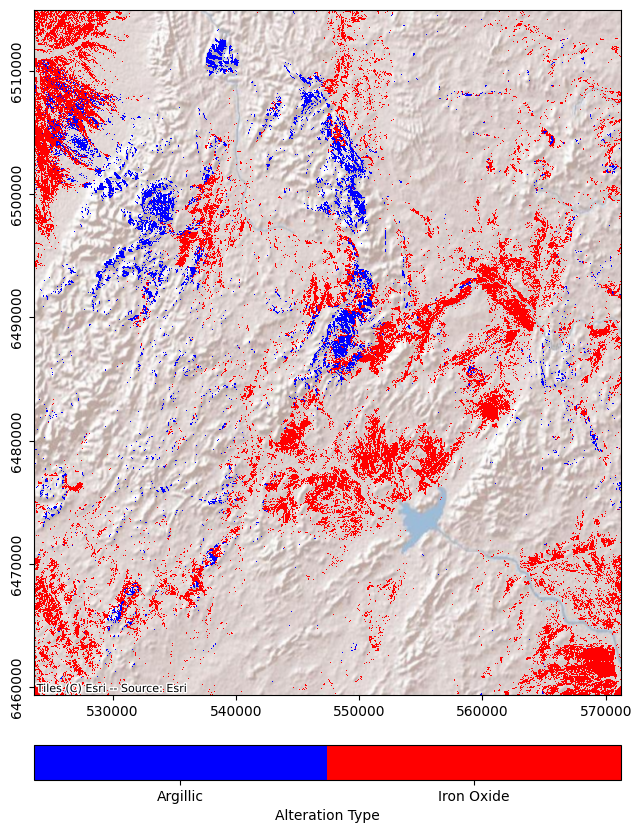

In [8]:
arrPred_fuzzy = arrFeatures_fuzzy
dsPred = dsFeatures

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred, (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat9_Manual_SVM_AlterationMap.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

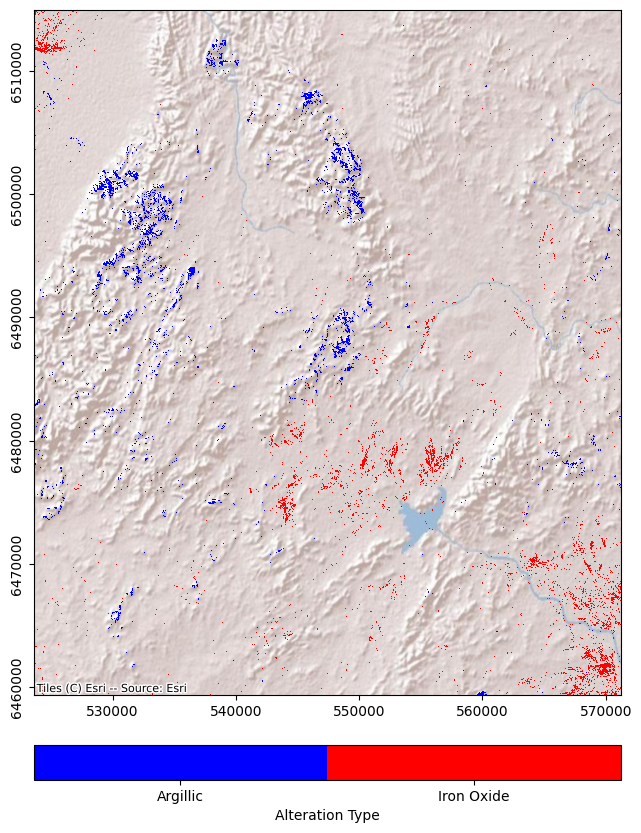

In [9]:
positiveLabel_file = './BrokenHill_Landsat9_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels_pca, arrPositiveLabels_pca = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels_pca))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

arrPositiveLabels_pca_copy = arrPositiveLabels_pca.copy()
arrPositiveLabels_pca_copy[arrPositiveLabels_pca_copy==0] = np.nan
image = plt.imshow(arrPositiveLabels_pca_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [10]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels_pca)
index = np.transpose(np.where(arrPositiveLabels_pca==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels_pca.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_pca_flat = arrPositiveLabels_pca.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_pca_flat!=0]
positiveLabels_pca = arrPositiveLabels_pca_flat[arrPositiveLabels_pca_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels_pca, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using SVM

In [11]:
model = SVC()
model.fit(train_x, train_y)
# predict for the test dataset
test_z = model.predict(test_x)
# calculate and display error metrics
cMatrix = confusion_matrix(test_y, test_z)
aScore = accuracy_score(test_y, test_z)
pScore = precision_score(test_y, test_z, average='macro')
rScore = recall_score(test_y, test_z, average='macro')
fscore = f1_score(test_y, test_z, average='macro')

print('Confusion matrix:\n', cMatrix)
print('\nAccuracy: %.3f, Precision: %.3f, Recall: %.3f, F1-Score: %.3f' % (aScore, pScore, rScore, fscore))

Confusion matrix:
 [[7838  147  165]
 [   0 8201   10]
 [   4    0 8052]]

Accuracy: 0.987, Precision: 0.987, Recall: 0.987, F1-Score: 0.987


### Mapping alteration zones

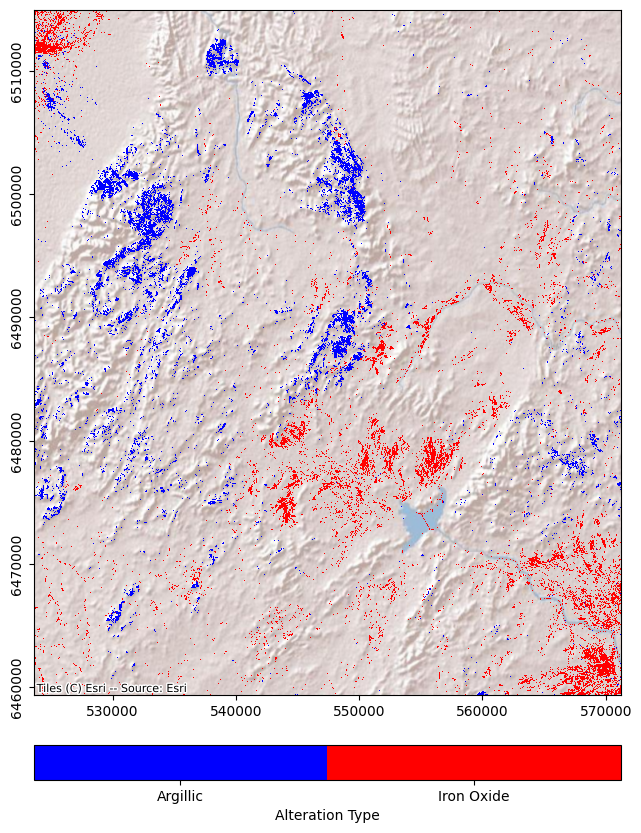

In [12]:
arrPred_fuzzy = arrFeatures_fuzzy
dsPred = dsFeatures

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred, (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = np.nan
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent, interpolation='nearest')

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

outFile = './Outputs/BrokenHill_Landsat9_PCA_SVM_AlterationMap.tif'
raster.export(pred_array, dsPred, filename=outFile, dtype='float')

In [13]:
pred_manual = pred[arrPositiveLabels_manual_flat!=0]
aScore = accuracy_score(positiveLabels_manual, pred_manual)
print(f'Accuracy based on ground truth data: {aScore}')

Accuracy based on ground truth data: 0.849
